In [1]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error


In [2]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [37]:
census_data = pd.read_csv('./inputs/census_starter.csv')
census_data.head()
census_data.pct_bb_2020.ffill(inplace=True)
census_data.pct_bb_2021.ffill(inplace=True)
census_data.pct_college_2020.ffill(inplace=True)
census_data.pct_college_2021.ffill(inplace=True)
census_data.pct_foreign_born_2020.ffill(inplace=True)
census_data.pct_foreign_born_2021.ffill(inplace=True)
census_data.pct_it_workers_2018.ffill(inplace=True)
census_data.pct_it_workers_2020.ffill(inplace=True)
census_data.pct_it_workers_2021.ffill(inplace=True)
census_data.median_hh_inc_2020.ffill(inplace=True)
census_data.median_hh_inc_2021.ffill(inplace=True)
census_data.median_hh_inc_2018.ffill(inplace=True)
census_data.isna().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64

In [3]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [4]:
def train_lr_model(cfip, clipped_lr = False, last_n = 15):
    columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]
    X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns]
    time_steps = list( range(len(X_cur)))
    X_cur.insert(0, "time_step", time_steps) 
    y_cur = mbd_data[ mbd_data.cfips == cfip ].loc[:,"microbusiness_density"]
    
    if clipped_lr: 
        X_cur = X_cur[-last_n:]
        y_cur = y_cur[-last_n:]

    X_train, X_test, y_train, y_test = train_test_split(X_cur, y_cur, test_size=0.1, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_smape = smape(y_train_pred, y_train)

    y_test_pred = model.predict(X_test)
    test_smape = smape(y_test_pred, y_test)

    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))

    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))
    
    return train_smape, test_smape, train_rmse, test_rmse


In [5]:
# if key  = -1 then  Unclustered, otherwise clustered 

best_performing_counties = []
df = pd.DataFrame(columns = ["Cluster", "Size", "Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
for index in [0,1,2,3,4,5,6,-1]:
    index = str(index)
    print(f"Cluster {index}")
    
    train_rmse_arr = []
    test_rmse_arr = []
    train_smape_arr = []
    test_smape_arr = []
    for cfip in tqdm(clusters[index]): 
        train_smape, test_smape, train_rmse, test_rmse = train_lr_model(cfip)
        if test_smape <0.02 : 
            best_performing_counties.append(cfip)
        else:
            new_train_smape, new_test_smape, new_train_rmse, new_test_rmse = train_lr_model(cfip,clipped_lr = True)
            if new_test_smape < 0.02 : 
                best_performing_counties.append(cfip)
                train_smape, test_smape, train_rmse, test_rmse = new_train_smape, new_test_smape, new_train_rmse, new_test_rmse            
        train_rmse_arr.append(train_rmse)
        test_rmse_arr.append(test_rmse)
        train_smape_arr.append(train_smape)
        test_smape_arr.append(test_smape)
    
    df.loc[len(df.index)] = [index, len(clusters[index]), round(np.mean(train_smape_arr),3), round(np.mean(test_smape_arr),3), round(np.mean(train_rmse_arr),3), round(np.mean(test_rmse_arr),3) ]



Cluster 0


100%|██████████████████████████████████████████████████████████████████████████████| 2527/2527 [01:09<00:00, 36.22it/s]


Cluster 1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 44.68it/s]


Cluster 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 71.31it/s]


Cluster 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.26it/s]


Cluster 4


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.68it/s]


Cluster 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.15it/s]


Cluster 6


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.21it/s]


Cluster -1


100%|████████████████████████████████████████████████████████████████████████████████| 555/555 [00:16<00:00, 34.65it/s]


In [6]:
df

,Cluster,Size,Train SMAPE,Validation SMAPE,Train RMSE,Validation RMSE
0,0,2527,0.018,0.027,0.049,0.067
1,1,13,0.007,0.008,0.084,0.082
2,2,3,0.008,0.012,0.106,0.116
3,3,4,0.005,0.009,0.085,0.108
4,4,26,0.008,0.010,0.078,0.097
5,5,4,0.020,0.022,0.139,0.112
6,6,3,0.020,0.028,0.140,0.139
7,-1,555,0.032,0.070,0.385,0.856


In [7]:
# best_performing_counties

In [8]:
train_smape, test_smape, train_rmse, test_rmse = train_lr_model(55099)
train_smape, test_smape

(0.0329447306852844, 0.07372291173287107)

In [9]:
updated_clusters = {}
for key in cluster_keys:
    updated_clusters[str(key)] = [cfip for cfip in clusters[key] if not (cfip in best_performing_counties)]

In [10]:
json.dump(updated_clusters, open("./outputs/clusters_lr.json", "w"))

In [11]:
updated_clusters = json.loads(open("./outputs/clusters_lr.json", "r").read())

In [12]:
best_performing_counties = []
df = pd.DataFrame(columns=["cfips","train_smape","test_smape"])
for key in clusters: 
    print("Cluster ",key)
    for cfip in tqdm(clusters[key]):
        train_smape, test_smape, train_rmse, test_rmse = train_lr_model(cfip)
        if test_smape <0.02 : 
            best_performing_counties.append([cfip,False])
        else:
            new_train_smape, new_test_smape, new_train_rmse, new_test_rmse = train_lr_model(cfip,clipped_lr = True)
            if new_test_smape < 0.02 : 
                best_performing_counties.append([cfip,True])
                train_smape, test_smape, train_rmse, test_rmse = new_train_smape, new_test_smape, new_train_rmse, new_test_rmse            
        df.loc[len(df.index)] = [cfip,train_smape, test_smape]
df

Cluster  0


100%|██████████████████████████████████████████████████████████████████████████████| 2527/2527 [01:14<00:00, 33.91it/s]


Cluster  4


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 45.79it/s]


Cluster  -1


100%|████████████████████████████████████████████████████████████████████████████████| 555/555 [00:17<00:00, 32.21it/s]


Cluster  1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 40.14it/s]


Cluster  2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 60.52it/s]


Cluster  3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.94it/s]


Cluster  5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.12it/s]


Cluster  6


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.85it/s]


,cfips,train_smape,test_smape
0,1001.0,0.015099,0.003976
1,1005.0,0.023296,0.017157
2,1007.0,0.021851,0.026874
3,1009.0,0.009489,0.008327
4,1011.0,0.010122,0.005303
...,...,...,...
3130,36007.0,0.017222,0.012675
3131,53047.0,0.038508,0.012319
3132,19189.0,0.026813,0.017952
3133,26097.0,0.030510,0.063010


In [13]:
df[ (df.test_smape.values <= 0.02) ].shape

(2238, 3)

In [14]:
# best_performing_counties

In [15]:
df

,cfips,train_smape,test_smape
0,1001.0,0.015099,0.003976
1,1005.0,0.023296,0.017157
2,1007.0,0.021851,0.026874
3,1009.0,0.009489,0.008327
4,1011.0,0.010122,0.005303
...,...,...,...
3130,36007.0,0.017222,0.012675
3131,53047.0,0.038508,0.012319
3132,19189.0,0.026813,0.017952
3133,26097.0,0.030510,0.063010


In [16]:
X= mbd_data[[ "cfips", "first_day_of_month", "pct_bb", "median_hh_inc", "pct_college", "pct_foreign_born", "pct_it_workers"]]
X = X.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
X.median_hh_inc.ffill(inplace=True)
X.pct_it_workers.ffill(inplace=True)
sc = MinMaxScaler()
X.median_hh_inc = sc.fit_transform( X.median_hh_inc.values.reshape(-1,1) ).reshape(-1)


In [28]:
def train_lr_model(cfip, clipped_lr = False, last_n = 12):
    columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]
    X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns]
    time_steps = list( range(len(X_cur)))
    X_cur.insert(0, "time_step", time_steps) 
    y_cur = mbd_data[ mbd_data.cfips == cfip ].loc[:,"microbusiness_density"]
    
    if clipped_lr: 
        X_cur = X_cur[-last_n:]
        y_cur = y_cur[-last_n:]

    X_train, X_test, y_train, y_test = train_test_split(X_cur, y_cur, test_size=0.1, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_smape = smape(y_train_pred, y_train)

    y_test_pred = model.predict(X_test)
    test_smape = smape(y_test_pred, y_test)

    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))

    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))
    
    columns = ["pct_bb_2021","median_hh_inc_2021","pct_college_2021", "pct_foreign_born_2021","pct_it_workers_2021"]
    X_forecast = census_data[census_data["cfips"] == cfip][columns]
    columns = [ "pct_bb", "median_hh_inc", "pct_college", "pct_foreign_born", "pct_it_workers"]
    X_forecast.columns = columns 
    X_forecast.median_hh_inc = sc.fit_transform(X_forecast.median_hh_inc.values.reshape(-1,1)).reshape(-1)
    X_forecast = X_forecast.values.reshape(-1)
    X_forecast = np.stack([X_forecast]*3,axis=0)
    time_step = list(range(len(y_train)+len(y_test),len(y_train)+len(y_test)+3))
    X_forecast = np.insert(X_forecast, 0,time_step,axis=1)
    X_forecast = pd.DataFrame(X_forecast, columns=["time_step"] + columns)
    y_forecast = model.predict(X_forecast)
    
    return np.concatenate([y_train,y_test]), np.concatenate([y_train_pred,y_test_pred, y_forecast])


In [18]:
dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
dates = [date.strftime('%Y-%m-%d') for date in dates]


In [19]:
cfip,clipped = best_performing_counties[6]


In [22]:
len(best_performing_counties)

2238

In [23]:
best_performing_counties2 = [x[0] for x in best_performing_counties]

In [46]:
best_smape_error = 0 

In [47]:

good_counter = 0 
poor_counter = 0 
for key in clusters: 
    for cfip in clusters[key]:
        if cfip in best_performing_counties2:
            idx = best_performing_counties2.index(cfip)
            cfip, clipped = best_performing_counties[idx]
        else:
            cfip, clipped = cfip, False
        
        y_true,y_pred = train_lr_model(cfip,clipped)
        
        x = list(range(len(y_pred)))
        location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
        plt.figure(figsize=(10,6))
        plt.plot(x[:len(y_true)],y_pred[:len(y_true)], label="Prediction")
        plt.plot(x[:len(y_true)],y_true, label="True")
        plt.plot(x[len(y_true):],y_pred[len(y_true):], label="Forecast")

        # Set the axis labels and title
        plt.xlabel('Date')
        plt.ylabel('Microbusiness Density')
        plt.title(f'{location} ( CFIP {cfip} ) ')
        plt.xticks(x[::4], dates[-len(x)::4], rotation=45)
        plt.legend()
        if cfip in best_performing_counties2:
#             plt.savefig(f"images/lr_results/good_fit/fig_{good_counter}")
            good_counter += 1
            best_smape_error += smape(y_true[-1:],y_pred[:len(y_true)][-1:])
        else: 
#             plt.savefig(f"images/lr_results/poor_fit/fig_{poor_counter}")
            poor_counter += 1
#         plt.show()
        plt.close()


In [48]:
best_smape_error2 = best_smape_error/good_counter

In [50]:
best_smape_error2 , best_smape_error, good_counter

(0.012455874213510909, 27.876246489837413, 2238)

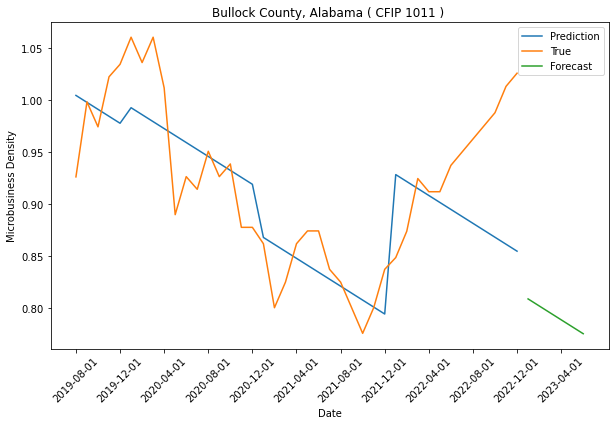

In [229]:
# cfip = best_performing_counties[3][0]
# y_true,y_pred = train_lr_model(cfip,clipped)
# x = list(range(len(y_pred)))
# location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
# plt.figure(figsize=(10,6))
# plt.plot(x[:len(y_true)],y_pred[:len(y_true)], label="Prediction")
# plt.plot(x[:len(y_true)],y_true, label="True")
# plt.plot(x[len(y_true):],y_pred[len(y_true):], label="Forecast")

# # Set the axis labels and title
# plt.xlabel('Date')
# plt.ylabel('Microbusiness Density')
# plt.title(f'{location} ( CFIP {cfip} ) ')
# plt.xticks(x[::4], dates[::4], rotation=45)
# plt.legend()


In [231]:
1011 in best_performing_counties2

True

In [ ]:
good_counter, poor_counter

In [87]:
census_data = pd.read_csv('./inputs/census_starter.csv')
census_data.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [95]:
census_data

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


In [134]:
for column in [ "pct_bb", "median_hh_inc", "pct_college", "pct_foreign_born", "pct_it_workers"]:
    print("current column :", column)
    df = census_data[["cfips",column + "_2017", column + "_2018", column + "_2019", column + "_2020", column + "_2021"]]
    df = df.set_index(df.cfips)
    
#     df2 = pd.DataFrame(columns = ["cfips", "year", column ])
#     for cfip in tqdm(cfips): 
#         for year in ["2017","2018","2019","2020","2021"] : 
#             df2.loc[len(df2.index)] = [cfip, str(int(year)+2), df.loc[cfip, column +"_"+ year]]
# #     df2.head()
#     mbd_data = mbd_data.merge(df2, left_on=["cfips","year"], right_on=["cfips","year"], how="left")

current column : pct_bb
current column : median_hh_inc
current column : pct_college
current column : pct_foreign_born
current column : pct_it_workers


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
1369,70.3,73.3,74.9,79.2,82.2,27111,17.3,17.7,17.4,18.0,...,2.2,1.9,1.9,2.2,2.1,55181,57131.0,58682,59456.0,63587.0


In [172]:
columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]

# np.insert(0,,X_forecast,axis=1)

In [169]:

time_step

[41, 42, 43]

array([[4.1000e+01, 8.2200e+01, 6.3587e+04, 1.8600e+01, 2.9000e+00,
        2.1000e+00],
       [4.2000e+01, 8.2200e+01, 6.3587e+04, 1.8600e+01, 2.9000e+00,
        2.1000e+00],
       [4.3000e+01, 8.2200e+01, 6.3587e+04, 1.8600e+01, 2.9000e+00,
        2.1000e+00]])